In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from skimage.filters import threshold_mean
from tensorflow.keras.datasets import mnist

In [40]:
class HopfieldNetwork(object):
    
    def train_weights(self, train_data):
        print("Start to train weights...")
        num_data =  len(train_data)
        self.num_neuron = train_data[0].shape[0]
        
        # initialize weights
        W = np.zeros((self.num_neuron, self.num_neuron))
        rho = np.sum([np.sum(t) for t in train_data]) / (num_data*self.num_neuron)
        
        # Hebb rule
        for i in tqdm(range(num_data)):
            t = train_data[i] - rho
            W += np.outer(t, t)
        
        # Make diagonal element of W into 0
        diagW = np.diag(np.diag(W))
        W = W - diagW
        W /= num_data
        
        self.W = W 
    
    def predict(self, data, num_iter=20, threshold=0, asyn=True):
        print("Start to predict...")
        self.num_iter = num_iter
        self.threshold = threshold
        self.asyn = asyn

        # Copy to avoid call by reference
        copied_data = np.copy(data)

        return [self._run(copied_data[i]) for i in tqdm(range(len(data)))]
    
    def _run(self, init_s):
        s = init_s
        if not self.asyn:
            """
            Synchronous update
            """
            e = self.energy(s)
            for _ in range(self.num_iter):
                s = np.sign(self.W @ s - self.threshold)
                e_new = self.energy(s)
                if e == e_new:
                    return s
                e = e_new
        else:
            """
            Asynchronous update
            """
            e = self.energy(s)
            for _ in range(self.num_iter):
                for _ in range(100):
                    idx = np.random.randint(0, self.num_neuron)
                    s[idx] = np.sign(self.W[idx].T @ s - self.threshold)
                e_new = self.energy(s)
                if e == e_new:
                    return s
                e = e_new
        return s
    
    
    def energy(self, s):
        return -0.5 * s @ self.W @ s + np.sum(s * self.threshold)

    def plot_weights(self):
        plt.figure(figsize=(6, 5))
        w_mat = plt.imshow(self.W, cmap=cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Network Weights")
        plt.tight_layout()
        plt.savefig("weights.png")
        plt.show()

In [109]:
# Utils
def reshape(data):
    dim = int(np.sqrt(len(data)))
    data = np.reshape(data, (dim, dim))
    return data

def plot(data, test, predicted, figsize=(6, 12)):
    data = [reshape(d) for d in data]
    test = [reshape(d) for d in test]
    predicted = [reshape(d) for d in predicted]
    
    fig, axarr = plt.subplots(len(data), 3, figsize=figsize)
    for i in range(len(data)):
        if i==0:
            axarr[i, 0].set_title('Train data')
            axarr[i, 1].set_title("Input data")
            axarr[i, 2].set_title('Output data')

        axarr[i, 0].imshow(data[i])
        axarr[i, 0].axis('off')
        axarr[i, 1].imshow(test[i])
        axarr[i, 1].axis('off')
        axarr[i, 2].imshow(predicted[i])
        axarr[i, 2].axis('off')
            
    plt.tight_layout()
    plt.savefig("result_mnist.png")
    plt.show()

def preprocessing(img):
    w, h = img.shape
    # Thresholding
    thresh = threshold_mean(img)
    binary = img > thresh
    shift = 2*(binary*1)-1 # Boolean to int

    # Reshape and return
    return np.reshape(shift, (w*h))

def run(img_select=3):
    # Load data
    (x_train, y_train), (_, _ )= mnist.load_data()
    data = []
    for i in range(img_select):
        xi = x_train[y_train==i]
        data.append(xi[0])
    
    # Preprocessing
    print("Start to data preprocessing...")
    data = [preprocessing(d) for d in data]
    
    # Create Hopfield Network Model
    model = HopfieldNetwork()
    model.train_weights(data)
    
    # Make test datalist
    test = []
    for i in range(img_select):
        xi = x_train[y_train==i]
        test.append(xi[1])
    test = [preprocessing(d) for d in test]
    
    predicted = model.predict(test, threshold=50, asyn=True)
    print("Show prediction results...")
    plot(data, test, predicted, figsize=(5, 5))
    print("Show network weights matrix...")
    model.plot_weights()

Start to data preprocessing...
Start to train weights...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 670.39it/s]


Start to predict...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.24it/s]

Show prediction results...


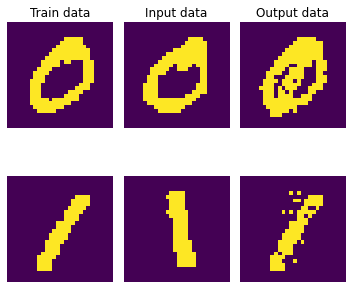

Show network weights matrix...


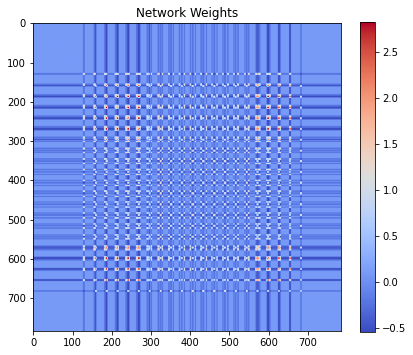

Start to data preprocessing...
Start to train weights...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 582.25it/s]


Start to predict...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.27it/s]


Show prediction results...


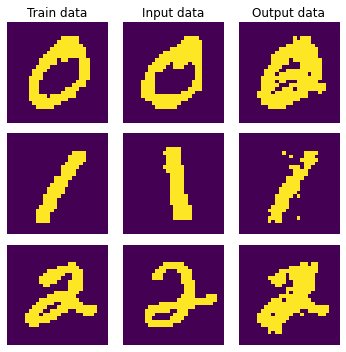

Show network weights matrix...


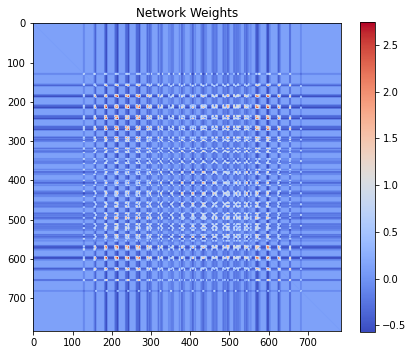

Start to data preprocessing...
Start to train weights...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 599.08it/s]


Start to predict...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.96it/s]


Show prediction results...


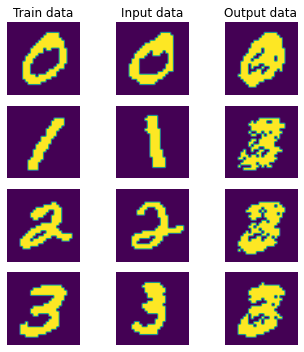

Show network weights matrix...


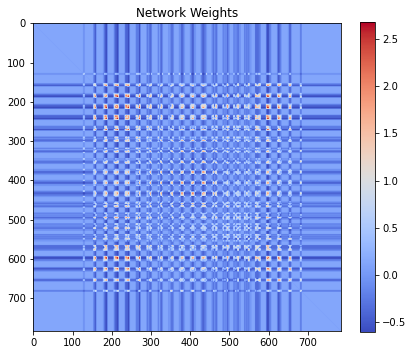

Start to data preprocessing...
Start to train weights...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 645.77it/s]


Start to predict...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.86it/s]


Show prediction results...


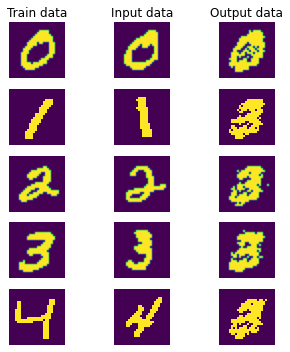

Show network weights matrix...


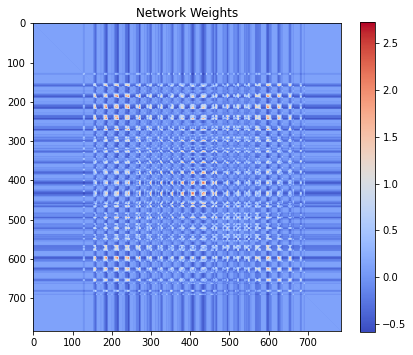

Start to data preprocessing...
Start to train weights...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 588.39it/s]


Start to predict...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.81it/s]


Show prediction results...


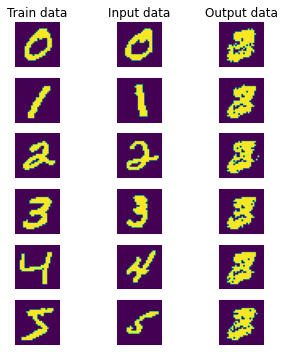

Show network weights matrix...


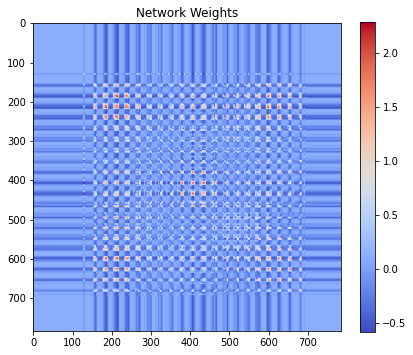

Start to data preprocessing...
Start to train weights...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 665.29it/s]


Start to predict...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 13.23it/s]


Show prediction results...


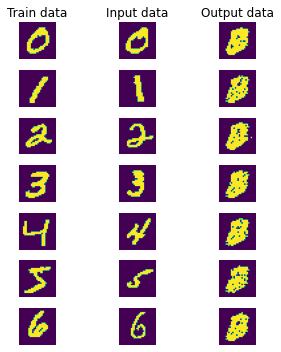

Show network weights matrix...


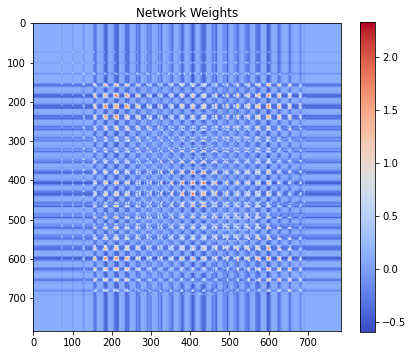

Start to data preprocessing...
Start to train weights...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 698.44it/s]


Start to predict...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 11.80it/s]


Show prediction results...


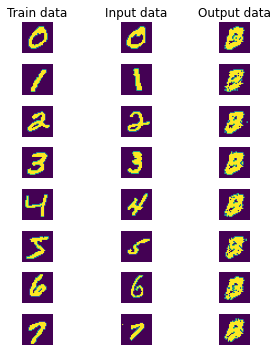

Show network weights matrix...


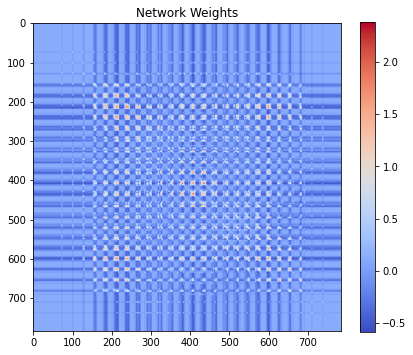

Start to data preprocessing...
Start to train weights...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 720.49it/s]


Start to predict...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 17.77it/s]


Show prediction results...


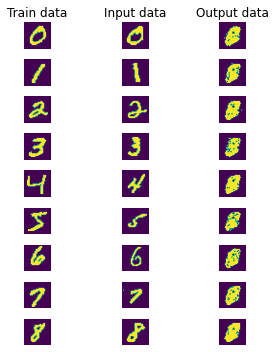

Show network weights matrix...


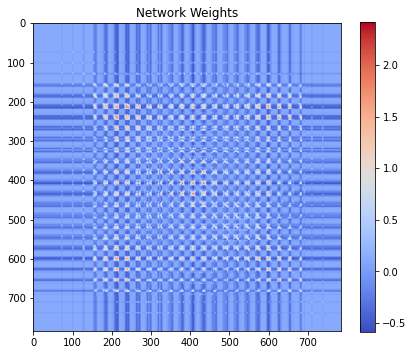

In [96]:
for i in range(2, 10, 1):
    run(i)

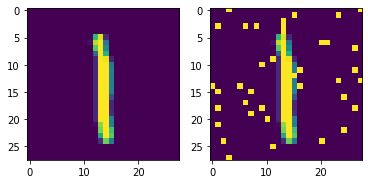

In [108]:
import skimage
(x_train, y_train), (_, _ )= mnist.load_data()
img_num = 14
noisy_img = skimage.util.random_noise(x_train[img_num], mode='salt', seed=None, clip=True)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_train[img_num])
ax[1].imshow(noisy_img)

# Task:
- Use hopfield network to reduce added noise on image